# TP 5

## Author : Petter Stahle
### Email : *petter.stahle@etu.unige.ch*

In [49]:
import numpy as np
from sklearn.metrics import mean_absolute_error as MAE, \
    mean_squared_error as MSE, accuracy_score
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from nn import NeuralNet
from pso import PSO

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format ='retina'

plt.style.use(['notebook', 'science', 'grid'])
import matplotlib as mlp
mlp.rcParams['text.usetex'] = False

np.set_printoptions(precision=3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [3]:
# import data
X = np.loadtxt('data/X.dat', delimiter=',')
print(X.shape)
print('Dynamic range: ', X[0].min(), ' - ', X[0].max())
y = np.loadtxt('data/Y.dat', dtype=int)
print(y.shape)

(200, 400)
Dynamic range:  0.0  -  1.0
(200,)


### Shuffle data

In [4]:
idx = np.arange(X.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

### Visualitze data

Note: we need to transpose the reshaped arrays because they are in a column-order and not row-order

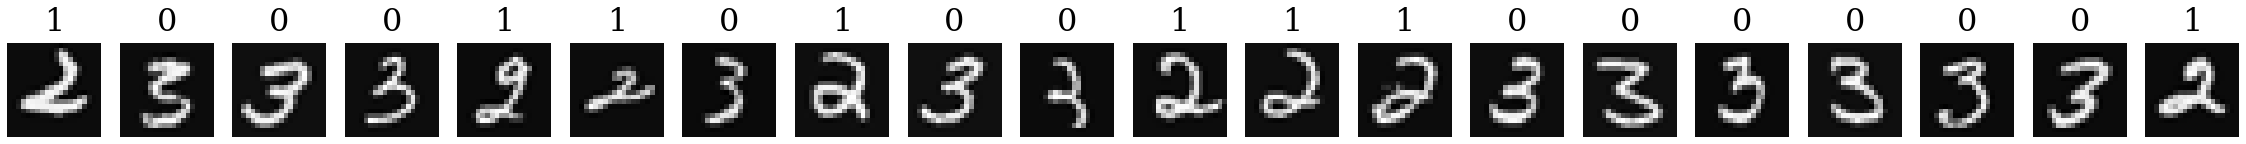

In [4]:
plt.figure(figsize=(20,4))
for i in range(20):
    plt.subplot(1,20,i+1)
    plt.imshow(X[i].reshape(20,20).T, cmap='gray')
    plt.title(y[i])
    plt.axis('off')


## NN application example

In [107]:
nn = NeuralNet()
v = nn.forward(X)
y_pred = nn.predict(X)

loss = MSE
print(loss(v, y))
print('initial accuracy: ', accuracy_score(y, y_pred))

0.44199579473473277
initial accuracy:  0.345


# PSO 

## Plot MSE as a function of iterations

In [18]:
n = 20
tmax = 500

nn_config = {
    'layers'                : (400,25,1),
    'kernel_norm_constraint': 0.5,
    'activation_function'   : 'sigmoid',
    'loss'                  : 'MSE'
}

pso = PSO(n, vmax=5)
losses = pso.fit(X, y, steps=tmax, track_losses=True, verbose=False)

In [47]:
# Compute cumulative global best loss

global_best_loss = [np.min(losses[0])]
for i in range(1, tmax+1):
    min_i = np.min(losses[i])
    global_best_loss.append(np.min([global_best_loss[i-1], min_i]))


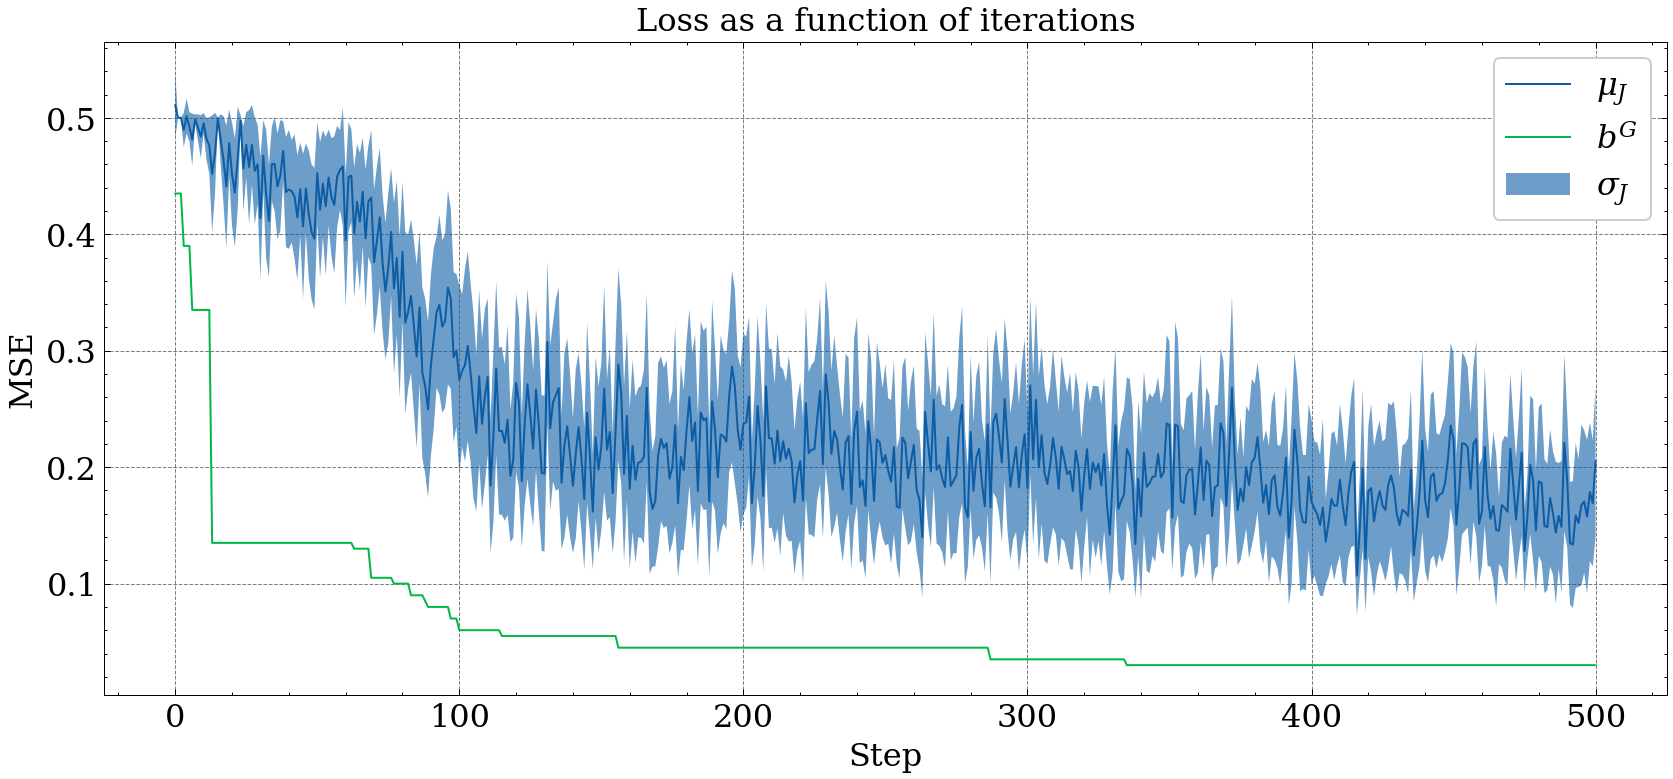

In [48]:
mean = np.mean(losses, axis=1)
std = np.std(losses, axis=1)
T = np.arange(tmax+1)
plt.figure(figsize=(14,6))
plt.plot(T, mean, label=r'$\mu_J$')
plt.fill_between(T, mean-std/2, mean+std/2, alpha=0.6, label=r'$\sigma_J$')
plt.plot(T, global_best_loss, label=r'$b^G$')

plt.xlabel(r'Step')
plt.ylabel(r'MSE')
plt.title('Loss as a function of iterations')
plt.legend()


## Average over 10 runs

In [59]:
losses = []
pred_error = []
tmax = 200
for i in tqdm(range(10)):
    pso = PSO(n, vmax=5)
    pso.fit(X, y, steps=tmax)
    losses.append(pso.global_best_loss)
    
    model = pso.get_best_model()
    y_pred = model.predict(X)
    pred_error.append(MAE(y, y_pred))

  0%|          | 0/10 [00:00<?, ?it/s]

### Losses (MSE)

In [57]:
print(losses)
print(np.std(losses))
print(np.mean(losses))

[0.09, 0.045, 0.065, 0.085, 0.05, 0.06, 0.075, 0.105, 0.055, 0.055]
0.018580904176062046
0.0685


### Prediction error (MAE) 

This is also equivalent to 1 - accuracy

In [60]:
print(pred_error)
print(np.std(pred_error))
print(np.mean(pred_error))

[0.09, 0.065, 0.04, 0.06, 0.05, 0.07, 0.07, 0.08, 0.1, 0.045]
0.018330302779823362
0.067


## Effect of $n$ on performance of PSO

In [72]:
N = [5, 10, 15, 20, 30, 40, 60, 80, 100, 200, 500]

best = []
std = []
mean = []

for n in tqdm(N):
    pso = PSO(n, vmax=0.5)
    losses = pso.fit(X, y, steps=100, track_losses=True, verbose=False)
    std.append(np.std(losses))
    mean.append(np.mean(losses))
    best.append(pso.global_best_loss)

  0%|          | 0/11 [00:00<?, ?it/s]

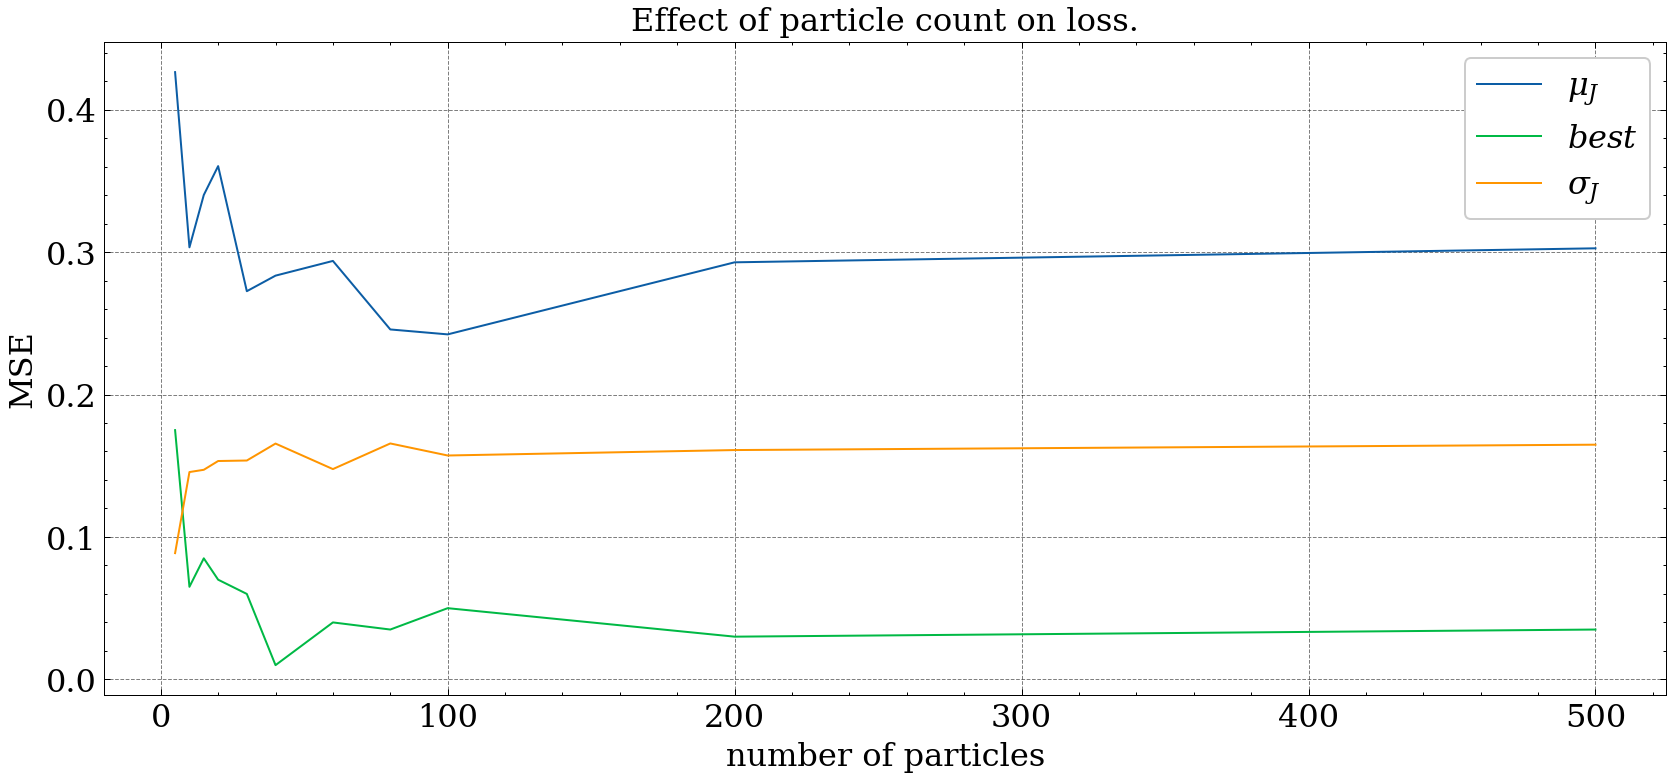

In [73]:
mean = np.array(mean)
std = np.array(std)

plt.figure(figsize=(14,6))
plt.plot(N, mean, label=r'$\mu_J$')
# plt.fill_between(N, mean-std/2, mean+std/2, alpha=0.6, )
plt.plot(N, best, label=r'$best$')
plt.plot(N, std, label=r'$\sigma_J$')

plt.xlabel(r'number of particles')
plt.ylabel(r'MSE')
plt.title('Effect of particle count on loss.')
plt.legend()

### Observation

As we observe in the above plot, as we increase the number of particles, we increase the number of possible solutions explored, i.e. instances of the neural network. This has an effect on improving the final optimal loss because we always keep the best, however it also has the effect of increasing the standard deviation, and after a certain threshold (around 100-200 particles), the mean loss even increases.



## Effect of $v_{max}$ on performance of PSO

In [74]:
V = np.linspace(0.05, 1, num=15)

best = []
std = []
mean = []

for v in tqdm(V):
    pso = PSO(40, vmax=v)
    losses = pso.fit(X, y, steps=100, track_losses=True, verbose=False)
    std.append(np.std(losses))
    mean.append(np.mean(losses))
    best.append(pso.global_best_loss)

  0%|          | 0/15 [00:00<?, ?it/s]

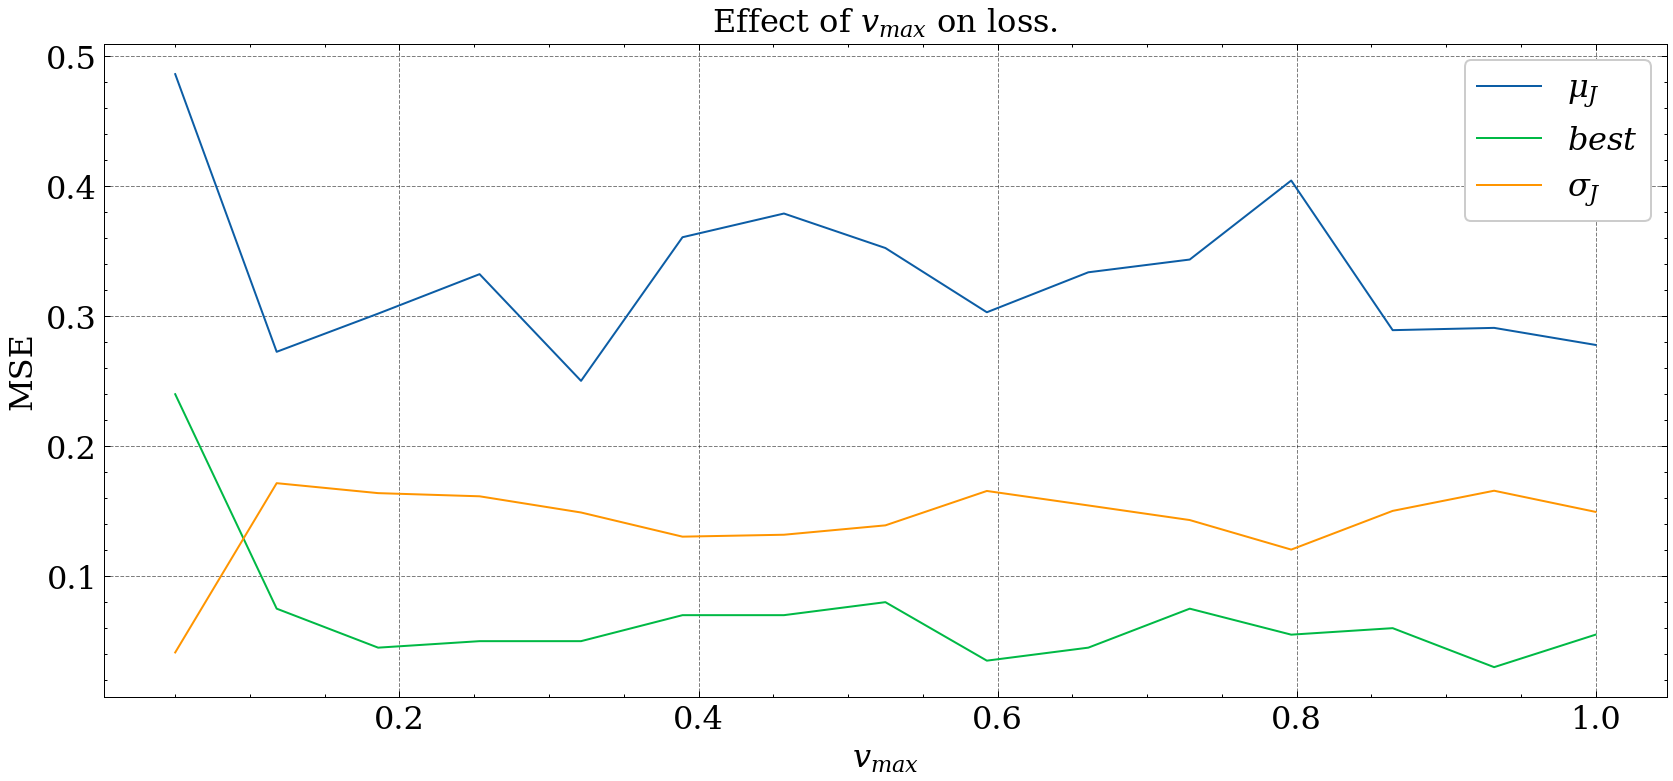

In [75]:
mean = np.array(mean)
std = np.array(std)

plt.figure(figsize=(14,6))
plt.plot(V, mean, label=r'$\mu_J$')
plt.plot(V, best, label=r'$best$')
plt.plot(V, std, label=r'$\sigma_J$')

plt.xlabel(r'$v_{max}$')
plt.ylabel(r'MSE')
plt.title(r'Effect of $v_{max}$ on loss.')
plt.legend()

In [87]:
V = [0.05, 0.3, 1]

best = []
mean = []

for v in tqdm(V):
    pso = PSO(40, vmax=v)
    losses = pso.fit(X, y, steps=100, track_losses=True, verbose=False)
    mean.append(np.mean(losses, axis=1))
    global_best_loss = [np.min(losses[0])]
    for i in range(1, 101):
        min_i = np.min(losses[i])
        global_best_loss.append(np.min([global_best_loss[i-1], min_i]))
    best.append(global_best_loss)

  0%|          | 0/3 [00:00<?, ?it/s]

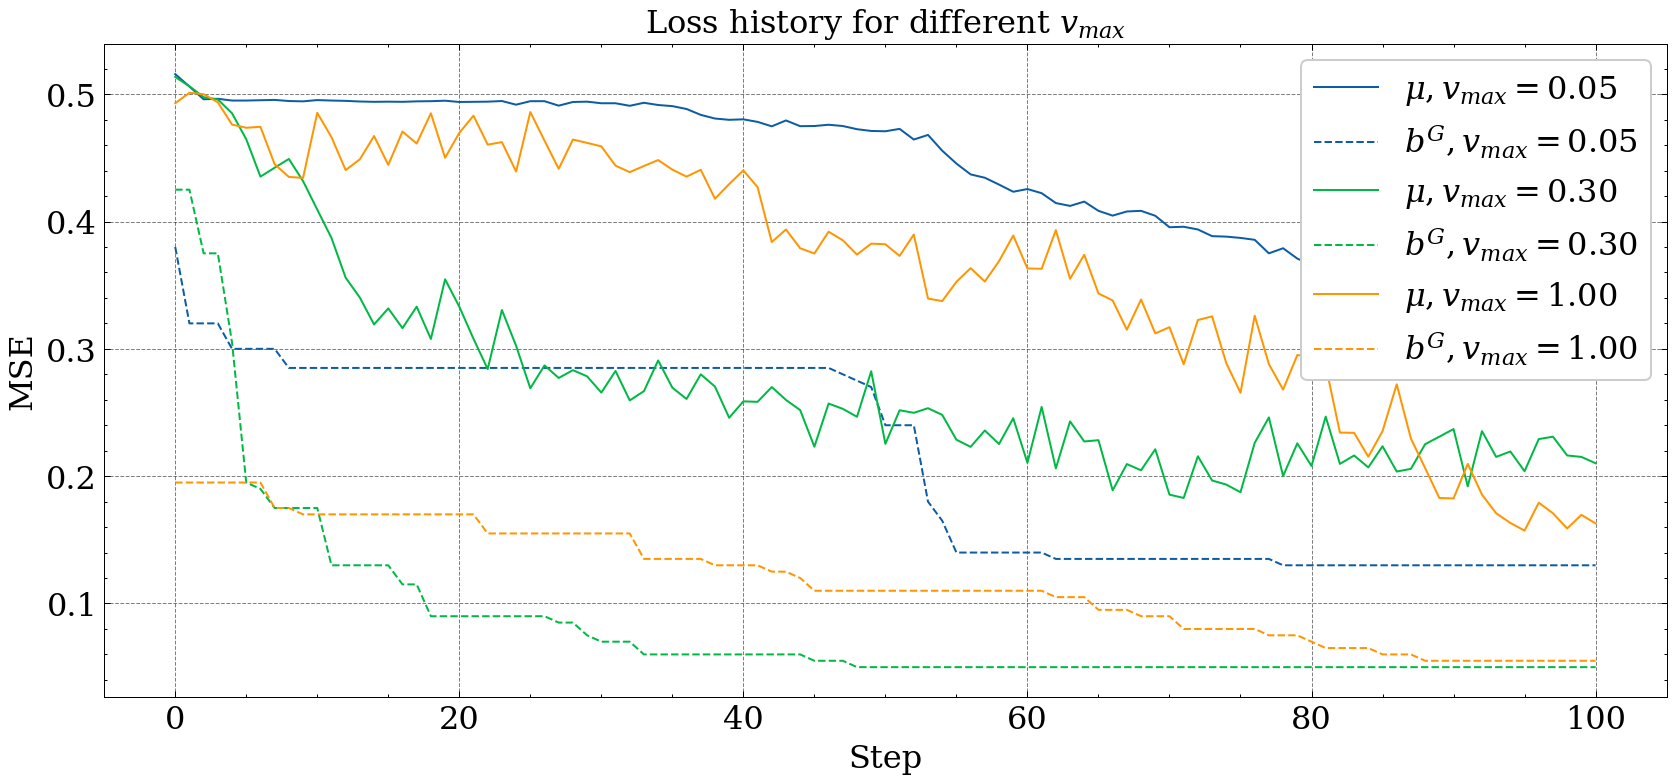

In [89]:
T = np.arange(101)
plt.figure(figsize=(14,6))
for i, v in enumerate(V):
    ax = plt.plot(T, mean[i], label=rf'$\mu, v_{{max}}={v:.2f}$')
    plt.plot(T, best[i], color=ax[0].get_color(), ls='dashed', label=rf'$b^G, v_{{max}}={v:.2f}$')

plt.xlabel(r'Step')
plt.ylabel(r'MSE')
plt.title(r'Loss history for different $v_{max}$')
plt.legend()

### Observation

We see in the second-last plot, that with a big enough $v_{max}$ ($\ >\sim 0.2\ $) the resulting loss doesn't change.

What is interesting to see though is that $v_max$ has an effect on the convergence, as can be seen in the last plot. This explains why above a certain cutoff our algorithm is able to converge for $t_{max}=100$. Furthermore, we also observe that we can somewhat tune $v_max$ to give us an optimal convergence rate. As we see in the last plot, $v_max=0.3$ converges faster than $1.0$, which intuitively can be explained by the fact that a high velocity will make particle weights exceed the given constraints (which in our case was an l_max norm of 0.5).

#### Note:
The way in which constrain violations are handled, is that a weight component which has exceeded the boundary will be reset to the nearest point on the boundary, and it's associated velocity component will be set to 0, as the direction of the particle was wrong since it would have pushed the particle outside the boundary.

## Discussion

One thing that must be noted also is that we only keep track of the training losses here, i.e. compute the losses bases on the available data our model was optimized ("trained" in ML jargon). This does not reflect actual losses experienced in production when the model is tested on a validation dataset. The fact that a PSO model is chosen based on the minimal training loss may have inherent weaknesses which would be interesting to explore, as it is common to find neural networks with very high variance when using backpropagation algorithms.